# Visualizing predictions

We visualize here a single stay's monitor augmented with predictions. Ichilov and Mayo stays are processed, using models trained on the Ichilov dataset.

In [1]:
import os
import re
import pickle
import pandas
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import ipywidgets
except Exception as e:
    print("cannot import ipywidgets: {}".format(e))
    ipywidgets = None
pandas.options.mode.chained_assignment = None 

CONCEPTS = ["HR", "InvBPDias", "InvBPSys", "SpO2",
            "Temperature monitor", "Central Venous Pressure",
            "RRtotal"]

Let's choose a stay and prediction model to visualize. 
* The first choice in model parameters is apparently the best one. 
* The window is used to smoothen NLLs, 15 min for Mayo and 60 min for Ichilov give the best picture.
* The threshold is just for drawing red dashed line on the average perplexity plot.

There is a list of all stays in Ichilov and Mayo towards the bottom of the notebook, copy and paste from there, or just keep a list of stays you want to look at elsewhere.

In [2]:
DELAY = 1

MODELS = ["HR,SpO2,InvBPSys,InvBPDias,RRtotal"]
ARCHS = ["rnn-128-3-0.5"]
DEPTHS = [15]
DELAYS = [15, 1]
WINDOWS = ['15min', '30min', '60min']
NLL_THRESHOLDS = (0, 4, 0.5)

STAYID = "Ichilov_MICU_20029"
MODEL = MODELS[0]
ARCH = ARCHS[0]
DEPTH = DEPTHS[0]
DELAY = DELAYS[0]
WINDOW = WINDOWS[0]
NLL_THRESHOLD = (NLL_THRESHOLDS[0] + NLL_THRESHOLDS[1])/2

if ipywidgets:
    @ipywidgets.interact
    def choose_stay(stayid=STAYID):
        global STAYID
        STAYID = stayid.strip()

    @ipywidgets.interact
    def choose_model(model=MODELS):
        global MODEL
        MODEL = model
        
    @ipywidgets.interact
    def choose_arch(arch=ARCHS):
        global ARCH
        ARCH = arch
        
    @ipywidgets.interact
    def choose_depth(depth=DEPTHS):
        global DEPTH
        DEPTH = depth
 
    @ipywidgets.interact
    def choose_delay(delay=DELAYS):
        global DELAY
        DELAY = delay
 
    @ipywidgets.interact
    def choose_stay(window=WINDOWS):
        global WINDOW
        WINDOW = window
        
    @ipywidgets.interact
    def choose_nll_threshold(nll_threshold=NLL_THRESHOLDS):
        global NLL_THRESHOLD
        NLL_THRESHOLD = nll_threshold

interactive(children=(Text(value='Ichilov_MICU_20029', description='stayid'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='model', options=('HR,SpO2,InvBPSys,InvBPDias,RRtotal',), value='HR,SpO2,InvBPSys,InvBPDias,RRtotal'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='arch', options=('rnn-128-3-0.5',), value='rnn-128-3-0.5'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='depth', options=(15,), value=15), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='delay', options=(15, 1), value=15), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='window', options=('15min', '30min', '60min'), value='15min'), Output()), _dom_classes=('widget-interact',))

interactive(children=(FloatSlider(value=2.0, description='nll_threshold', max=4.0, step=0.5), Output()), _dom_classes=('widget-interact',))

In [81]:
STAY = "../data/monitor-dataset-{}-predict-{}-{}:{}-{}.pkl".format(STAYID, MODEL, DEPTH, DELAY, ARCH)
with open(STAY, "rb") as f:
    df = pickle.load(f)
# You can cut off a region of the dataframe like this:
# df = df[1*len(df)//2:5*len(df)//8]

## Per-axis predictions

For each concept we show two plots side by side. 
* On the left-hand plot the confidence intervals are shown (in pale orange). The  actual measurements are in blue.
* The right-hand plot shows negative log-likelihood (NLL) of predictions, averaged over a rolling window. The orange is the NLL. NLL should jump on low-confidence regions, corresponding to high variability or trend change. The pale blue background shows actual measurements, shifted two zero mean and scaled for easier comparison with NLL.

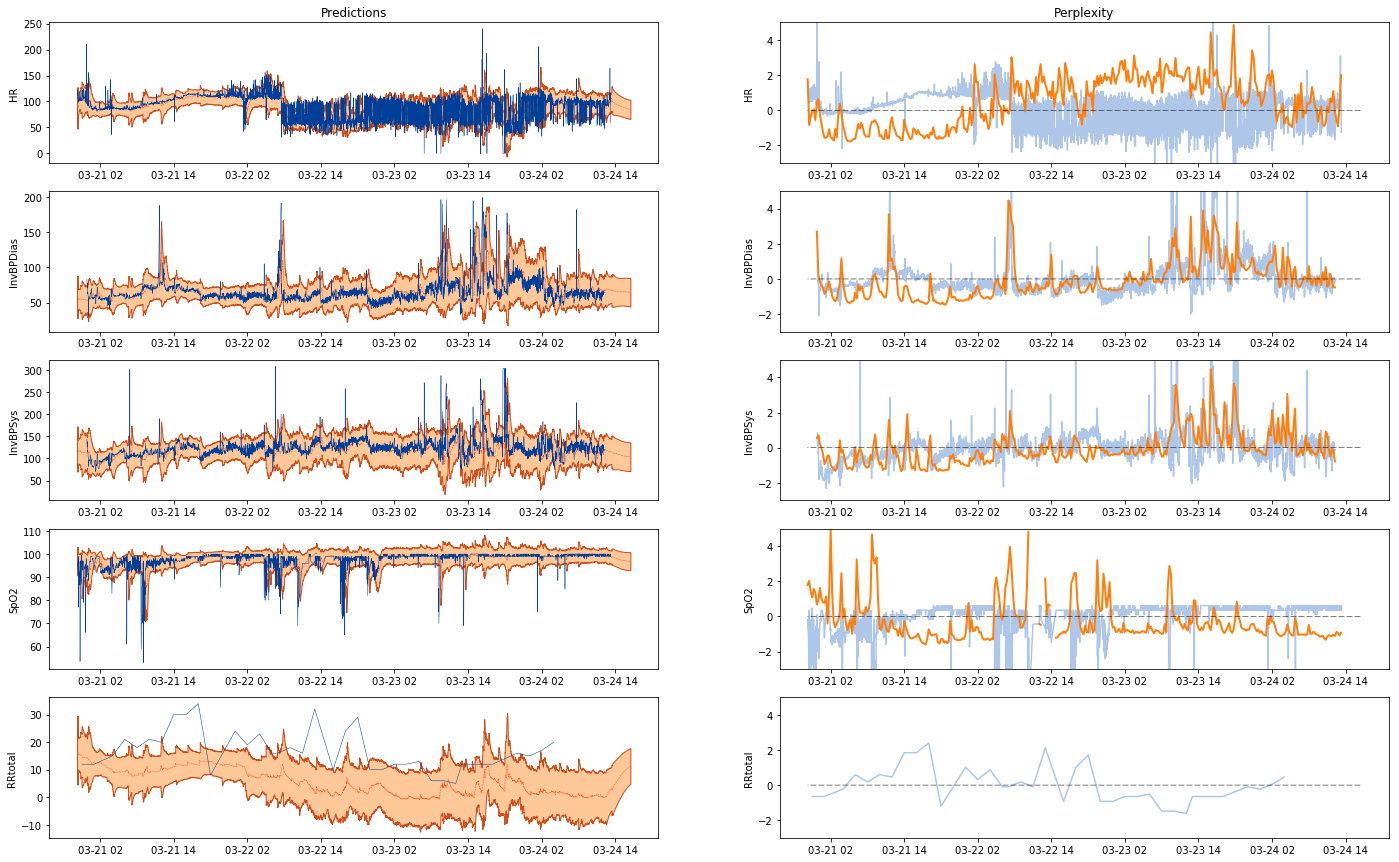

In [82]:
MAX_NLL = 5
MIN_NLL = -3

NSTDS = 2  # hose radius, in standard deviations

def cutoff(nll):
    """Cutoffs extreme NLL values for better presentation
    """
    shift = (MAX_NLL + MIN_NLL)/2
    scale = (MAX_NLL - MIN_NLL)/2
    return scale*numpy.tanh((nll - shift)/scale) + shift

def scale(concept):
    """Scales concept to display with NLL
    """
    return (concept - concept.mean())/concept.std()

concepts = [c for c in CONCEPTS if c + "_mean" in set(df.columns)]
fig, sps = plt.subplots(len(concepts), 2)
fig.set_figwidth(24)
fig.set_figheight(3*len(concepts))
avg_nll = None
any_avail = None
any_counts = None
for i, c in enumerate(concepts):
    avail = numpy.logical_not(numpy.isnan(df[c]))
    
    # Concept prediction
    mean = df[c + "_mean"]
    std = df[c + "_std"]
    sps[i, 0].fill_between(df.index, mean - NSTDS * std, mean + NSTDS * std,
                         edgecolor='#CC4F1B', facecolor='#FFC898')
    sps[i, 0].plot(mean, '--', lw=0.5, c='#FF4F1B')
    sps[i, 0].plot(df[c][avail], c='#003F99', lw=0.5)
    sps[i, 0].set_ylabel(c)
    
    # Concept perplexity
    zero = df[c].copy()
    zero[:] = 0.
    sps[i, 1].plot(scale(df[c][avail]), c='#AEC7E8')
    sps[i, 1].plot(cutoff(df[c + "_nll"][avail]).resample(rule=WINDOW).mean(), c='#FF7F0E', lw=2)
    sps[i, 1].plot(zero, c='black', linestyle=(-6, [12, 4]), lw=0.5)
    sps[i, 1].set_ylim((MIN_NLL, MAX_NLL))
    
    # Accumulate average perplexity
    c_nll = df[c + "_nll"].copy()
    c_nll[numpy.logical_not(avail)] = 0.
    c_counts = c_nll.copy()
    c_counts[:] = 0
    c_counts[avail] = 1
    if avg_nll is None:
        avg_nll = c_nll
        any_avail = avail
        any_counts = c_counts
    else:
        avg_nll += c_nll
        any_avail = numpy.logical_or(any_avail, avail)
        any_counts += c_counts
    
    sps[i, 1].set_ylabel(c)
avg_nll /= any_counts

sps[0, 0].set_title("Predictions")
sps[0, 1].set_title("Perplexity")

## Average log-perplexity

We draw average perplexity over all available measurements, averaged over a window. Faint lines in the background are normalized monitor measurements, for easier orientation.

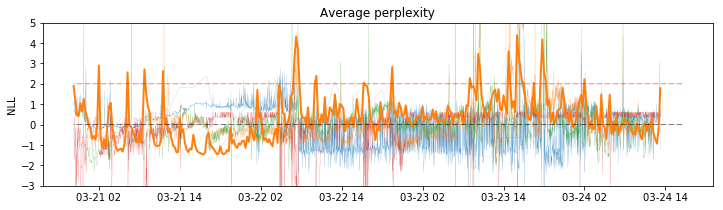

In [83]:
fig, sp = plt.subplots(1, 1)
fig.set_figwidth(12)
fig.set_figheight(3)
zero = avg_nll.copy()
zero[:] = 0.
threshold = avg_nll.copy()
threshold[:] = NLL_THRESHOLD
for c in concepts:
    avail = numpy.logical_not(numpy.isnan(df[c]))
    # we add here very faint monitor lines for orientation
    sp.plot(scale(df[c][avail]), lw=0.1*(1 + numpy.log(len(any_avail)/len(any_avail[any_avail]))))

win_nll = cutoff(avg_nll[any_avail]).resample(rule=WINDOW).mean()

sp.plot(win_nll, c='#FF7F0E', lw=2)
sp.plot(zero, c='black', linestyle=(-6, [12, 4]), lw=0.5)
sp.plot(threshold, c='red', linestyle=(-6, [12, 4]), lw=0.5)
sp.set_ylim((MIN_NLL, MAX_NLL))
sp.set_ylabel("NLL")
sp.set_title("Average perplexity")

## Appendix A: KS tag test

For stays from Ichilov, we can compare alerts to tags by performing a kind of KS test.

In [70]:
STAYS = "../data/stay_tags.pkl"
with open(STAYS, "rb") as f:
    stays = pickle.load(f)

if STAYID in stays:
    print("{} has {} tags".format(STAYID, len([tag for tag in stays[STAYID]])))
else:
    print("no tags")

Ichilov_MICU_25712 has 16 tags


Let's extract the tag time series.

In [76]:
times = sorted(set([tag['time'] for tag in stays[STAYID] if 'deterioration' in tag['concept']]))

tags = pandas.DataFrame({'time': times, 'tag': [1] * len(times)})
tags['time'] = pandas.to_datetime(tags['time'])
tags = tags.set_index('time')
tags = tags.reindex(df.index, fill_value=0)

Now let us merge the tags with window nll.

In [77]:
tags['nll'] = numpy.maximum(win_nll, 0) - 0
tags['nll'][numpy.isnan(tags['nll'])] = 0
tags['alert'] = numpy.sign(numpy.maximum(win_nll, NLL_THRESHOLD) - NLL_THRESHOLD)
tags['alert'][numpy.isnan(tags['alert'])] = 0

Finally, it's time to compute cumulative tags.

In [78]:
tags['cumtag'] = tags.cumsum()['tag']
tags['cumtag'] /= tags['cumtag'][-1]
tags['cumnll'] = tags.cumsum()['nll']
tags['cumnll'] /= tags['cumnll'][-1]
tags['cumalert'] = tags.cumsum()['alert']
tags['cumalert'] /= tags['cumalert'][-1]

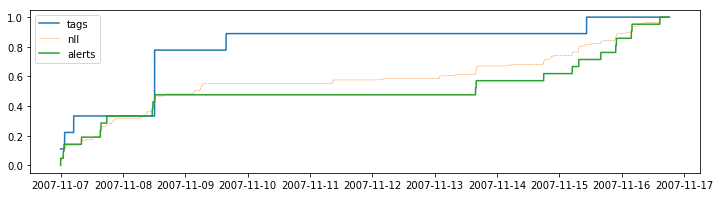

In [79]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(12)
fig.set_figheight(3)
ax.plot(tags['cumtag'], label='tags')
ax.plot(tags['cumnll'], '--', lw=0.5, label='nll')
ax.plot(tags['cumalert'], label='alerts')
ax.legend()

In [64]:
diffs = tags['cumalert'] - tags['cumtag']
print("KS statistics={:.4f} (max={:.4f} min={:.4f}, mean={:.4f})"
      .format(diffs.abs().max(), diffs.max(), diffs.min(), diffs.abs().mean()))

KS statistics=0.5000 (max=0.5000 min=-0.2500, mean=0.1836)


In [80]:
stays[STAYID]

[{'concept': 'deterioration_pan_shock', 'time': '2007-11-06T23:59:00Z'},
 {'concept': 'deterioration_physiology_shock', 'time': '2007-11-07T01:30:00Z'},
 {'concept': 'septic_shock_campaign', 'time': '2007-11-07T01:54:00Z'},
 {'concept': 'deterioration_pan_shock', 'time': '2007-11-07T05:00:00Z'},
 {'concept': 'septic_shock_campaign', 'time': '2007-11-07T12:49:00Z'},
 {'concept': 'septic_shock_campaign', 'time': '2007-11-08T02:59:00Z'},
 {'concept': 'deterioration_shock', 'time': '2007-11-08T12:10:00Z'},
 {'concept': 'shock', 'time': '2007-11-08T12:10:00Z'},
 {'concept': 'deterioration_light_shock', 'time': '2007-11-08T12:10:00Z'},
 {'concept': 'deterioration_pan_shock', 'time': '2007-11-08T12:10:00Z'},
 {'concept': 'deterioration_pan_shock', 'time': '2007-11-09T15:42:00Z'},
 {'concept': 'septic_shock_campaign', 'time': '2007-11-11T04:13:00Z'},
 {'concept': 'septic_shock_campaign', 'time': '2007-11-11T17:59:00Z'},
 {'concept': 'septic_shock_campaign', 'time': '2007-11-12T07:33:00Z'},
 {'

## Appendix B: stay lists

Copy and paste into the text field above.

### Mayo

In [17]:
for stay in sorted(os.listdir("../data")):
    m = re.match("^.*(Mayo_MICU_......._........)\.pkl", stay)
    if m:
        print(m.group(1))

Mayo_MICU_3003043_20840918
Mayo_MICU_3003AY3_20420313
Mayo_MICU_30040AY_20620101
Mayo_MICU_300483Y_20350504
Mayo_MICU_3006YA0_20390409
Mayo_MICU_3008330_20810505
Mayo_MICU_30099MA_20371213
Mayo_MICU_300A0AM_20381030
Mayo_MICU_300Y4A8_20621012
Mayo_MICU_300Y8YM_20600726
Mayo_MICU_300Y8YM_20600829
Mayo_MICU_303049Y_20311010
Mayo_MICU_30308MA_20430531
Mayo_MICU_303093M_20340821
Mayo_MICU_303300O_20361231
Mayo_MICU_3033M34_20840305
Mayo_MICU_3034Y46_20470602
Mayo_MICU_30369Y3_20690506
Mayo_MICU_3036AA0_20400908
Mayo_MICU_3036AA0_20400926
Mayo_MICU_3036AA0_20401013
Mayo_MICU_3036AA0_20401110
Mayo_MICU_303A840_20591026
Mayo_MICU_303AMMA_20590302
Mayo_MICU_3043O46_20611113
Mayo_MICU_3044A30_20351227
Mayo_MICU_3044A30_20351230
Mayo_MICU_304638M_20340830
Mayo_MICU_3046O38_20750805
Mayo_MICU_304A6A4_20491216
Mayo_MICU_304A990_20571213
Mayo_MICU_304A990_20580328
Mayo_MICU_304M343_20410316
Mayo_MICU_304M869_20540714
Mayo_MICU_304MY4Y_20730330
Mayo_MICU_304OOAO_20460916
Mayo_MICU_304Y64A_20420509
M

Mayo_MICU_4OYY364_20580720
Mayo_MICU_4Y00068_20220425
Mayo_MICU_4Y04M36_20421008
Mayo_MICU_4Y06Y93_21010708
Mayo_MICU_4Y08YM3_20430223
Mayo_MICU_4Y08YM3_20440105
Mayo_MICU_4Y08YM3_20440504
Mayo_MICU_4Y0O480_20381021
Mayo_MICU_4Y0OYA0_20461128
Mayo_MICU_4Y0Y604_20690412
Mayo_MICU_4Y0YY88_20810829
Mayo_MICU_4Y3039A_20691118
Mayo_MICU_4Y386O9_20390516
Mayo_MICU_4Y38AA0_20570514
Mayo_MICU_4Y38M06_20370310
Mayo_MICU_4Y3AOY9_20370412
Mayo_MICU_4Y3AOY9_20381009
Mayo_MICU_4Y3MMO9_20740923
Mayo_MICU_4Y3MMO9_20760118
Mayo_MICU_4Y3MMO9_20770228
Mayo_MICU_4Y3MMO9_20770507
Mayo_MICU_4Y3MMO9_20770531
Mayo_MICU_4Y3MMO9_20770620
Mayo_MICU_4Y3MMO9_20770920
Mayo_MICU_4Y3MMO9_20771031
Mayo_MICU_4Y3MMO9_20771227
Mayo_MICU_4Y3MMO9_20780125
Mayo_MICU_4Y3O4Y6_20930930
Mayo_MICU_4Y3O844_20490404
Mayo_MICU_4Y3OAO9_20810111
Mayo_MICU_4Y3Y643_20440121
Mayo_MICU_4Y44343_20740507
Mayo_MICU_4Y44836_20710917
Mayo_MICU_4Y48MAM_20451221
Mayo_MICU_4Y493OM_20571019
Mayo_MICU_4Y4946A_20341003
Mayo_MICU_4Y4946A_20341113
M

Mayo_MICU_A3AAYMM_20790309
Mayo_MICU_A3AM3O8_20640325
Mayo_MICU_A3AM9M9_20900907
Mayo_MICU_A3AMA3A_20511109
Mayo_MICU_A3AOMY9_20940309
Mayo_MICU_A3AY68M_20660707
Mayo_MICU_A3AYM69_20531216
Mayo_MICU_A3M06M3_20431127
Mayo_MICU_A3M0A98_20770416
Mayo_MICU_A3M0A98_20770419
Mayo_MICU_A3M0A98_20770528
Mayo_MICU_A3M0M0A_20600719
Mayo_MICU_A3M0M0A_20600921
Mayo_MICU_A3M0Y06_20660609
Mayo_MICU_A3M308Y_20810728
Mayo_MICU_A3M308Y_20810802
Mayo_MICU_A3M38YO_20860228
Mayo_MICU_A3M3M0A_20550526
Mayo_MICU_A3M3M0A_20550529
Mayo_MICU_A3M4399_20700208
Mayo_MICU_A3M4399_20700210
Mayo_MICU_A3M4894_20900429
Mayo_MICU_A3M4AMO_20570318
Mayo_MICU_A3M649M_20960602
Mayo_MICU_A3M664Y_20870824
Mayo_MICU_A3M664Y_20870902
Mayo_MICU_A3M8433_20710304
Mayo_MICU_A3M860A_20640716
Mayo_MICU_A3M8998_20561113
Mayo_MICU_A3M8998_20561129
Mayo_MICU_A3M9038_20501214
Mayo_MICU_A3M9984_20730730
Mayo_MICU_A3M9MAY_20770611
Mayo_MICU_A3M9MAY_20770623
Mayo_MICU_A3M9MAY_20770626
Mayo_MICU_A3MAO43_20840324
Mayo_MICU_A3MM0YM_20470831
M

Mayo_MICU_O89M46O_20680610
Mayo_MICU_O89OMMY_20601023
Mayo_MICU_O89YMM4_20701229
Mayo_MICU_O8A3AAM_21020607
Mayo_MICU_O8A3AAM_21030509
Mayo_MICU_O8A8A49_20411214
Mayo_MICU_O8A9OOY_20911217
Mayo_MICU_O8AA080_20651013
Mayo_MICU_O8AA3O3_20870413
Mayo_MICU_O8AAMAM_21090628
Mayo_MICU_O8AAO38_20380112
Mayo_MICU_O8AM6AO_20780407
Mayo_MICU_O8AM8AO_20460626
Mayo_MICU_O8AM8AO_20460705
Mayo_MICU_O8AM8AO_20460710
Mayo_MICU_O8AM8AO_20460714
Mayo_MICU_O8AM8AO_20460729
Mayo_MICU_O8AM8AO_20480927
Mayo_MICU_O8AMO9A_20581102
Mayo_MICU_O8AMO9A_20581108
Mayo_MICU_O8AMYOA_20600212
Mayo_MICU_O8AOA8Y_20640917
Mayo_MICU_O8AOA8Y_20640923
Mayo_MICU_O8AOA8Y_20690628
Mayo_MICU_O8M040A_20511215
Mayo_MICU_O8M09A8_20800121
Mayo_MICU_O8M48MO_20390822
Mayo_MICU_O8M4A4A_20370513
Mayo_MICU_O8M4A4A_20370518
Mayo_MICU_O8M6430_20400405
Mayo_MICU_O8M6644_20800618
Mayo_MICU_O8M6A84_20470118
Mayo_MICU_O8M8MA3_20831124
Mayo_MICU_O8M94AO_20980417
Mayo_MICU_O8M94AO_20990122
Mayo_MICU_O8M94AO_21000311
Mayo_MICU_O8M94YO_20380328
M

### Ichilov

In [157]:
for stay in sorted(os.listdir("../data")):
    m = re.match("^.*(Ichilov_MICU_.....)\.pkl", stay)
    if m:
        print(m.group(1))

Ichilov_MICU_20001
Ichilov_MICU_20002
Ichilov_MICU_20004
Ichilov_MICU_20005
Ichilov_MICU_20006
Ichilov_MICU_20007
Ichilov_MICU_20008
Ichilov_MICU_20009
Ichilov_MICU_20010
Ichilov_MICU_20011
Ichilov_MICU_20012
Ichilov_MICU_20013
Ichilov_MICU_20014
Ichilov_MICU_20015
Ichilov_MICU_20016
Ichilov_MICU_20017
Ichilov_MICU_20018
Ichilov_MICU_20019
Ichilov_MICU_20020
Ichilov_MICU_20021
Ichilov_MICU_20022
Ichilov_MICU_20023
Ichilov_MICU_20024
Ichilov_MICU_20025
Ichilov_MICU_20026
Ichilov_MICU_20027
Ichilov_MICU_20028
Ichilov_MICU_20029
Ichilov_MICU_20030
Ichilov_MICU_20031
Ichilov_MICU_20032
Ichilov_MICU_20033
Ichilov_MICU_20034
Ichilov_MICU_20035
Ichilov_MICU_20036
Ichilov_MICU_20037
Ichilov_MICU_20038
Ichilov_MICU_20039
Ichilov_MICU_20040
Ichilov_MICU_20041
Ichilov_MICU_20042
Ichilov_MICU_20043
Ichilov_MICU_20044
Ichilov_MICU_20045
Ichilov_MICU_20046
Ichilov_MICU_20047
Ichilov_MICU_20048
Ichilov_MICU_20049
Ichilov_MICU_20050
Ichilov_MICU_20051
Ichilov_MICU_20052
Ichilov_MICU_20053
Ichilov_MICU